In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm_notebook
import numpy as np
import datetime

In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        plt.tight_layout()
    return

In [3]:
def optimizeSARIMA(data, parameters_list, d, D, s):    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def plotSARIMA(series, model, s, d, n_steps):
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    # forecast.index = forecast.index.to_timestamp(freq='D')
    # forecast.index = pd.DatetimeIndex(forecast.index).to_period('D')
    plt.plot(forecast, color='r', label="model")
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

# Реальный ряд

Для примера взяты реальные данные цен акций компании Apple.

<AxesSubplot:title={'center':'Apple stocks'}, xlabel='time'>

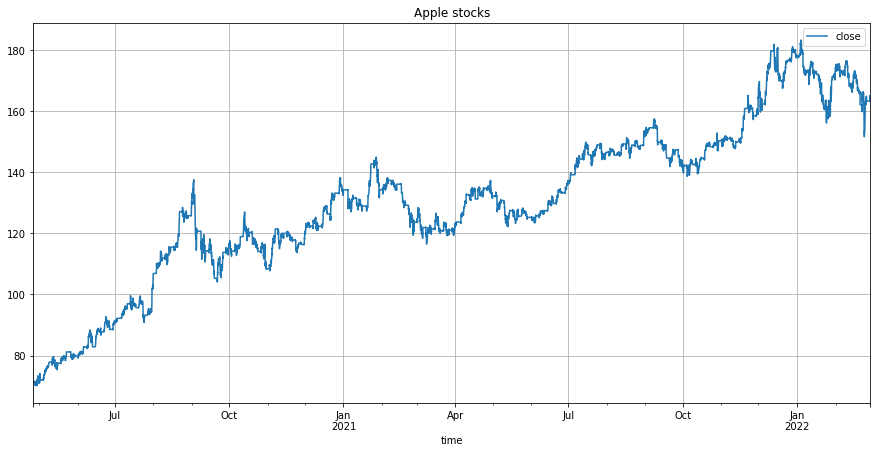

In [6]:
dataset = pd.read_csv('D:/2022/reduced-trading-ds/AAPL.csv', index_col='time', parse_dates=['time'])
dataset = dataset.resample('H').mean()
dataset = dataset.fillna(dataset.bfill())

dataset = dataset[3000:]
data = dataset.loc[:, 'close']
data = data.to_frame()
# dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAPL.csv', parse_dates=['Date'], dayfirst=True)
# dataset = dataset[3000:]
# data = dataset.copy()
# data['Time'] = data.Date.dt.time
# data['Date'] = data['Date'].astype(str) + ' ' + data['Time'].astype(str)
# data = data.set_index('Date')
# data = data.loc[:, 'Adj Close']
# data = data.to_frame()
# data.index = pd.DatetimeIndex(data.index).to_period('D')
data.plot(figsize=(15, 7), title='Apple stocks', grid=True)

In [7]:
dataset.shape

(16168, 5)

In [8]:
dataset.head()

,open,high,low,close,volume
time,,,,,
2020-04-26 07:00:00+00:00,71.3785,71.424125,71.361542,71.39225,176.866667
2020-04-26 08:00:00+00:00,71.3785,71.424125,71.361542,71.39225,176.866667
2020-04-26 09:00:00+00:00,71.3785,71.424125,71.361542,71.39225,176.866667
2020-04-26 10:00:00+00:00,71.3785,71.424125,71.361542,71.39225,176.866667
2020-04-26 11:00:00+00:00,71.3785,71.424125,71.361542,71.39225,176.866667


In [9]:
data.tail()

,close
time,
2022-02-28 18:00:00+00:00,164.359500
2022-02-28 19:00:00+00:00,163.124333
2022-02-28 20:00:00+00:00,163.699667
2022-02-28 21:00:00+00:00,164.882000
2022-02-28 22:00:00+00:00,164.844444


In [10]:
type(data)

pandas.core.frame.DataFrame

Для проверки на стационарность проведем тест Дикки-Фуллера:

In [12]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['close'])[1])

Критерий Дики-Фуллера: p=0.314864


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать. Возьмем первые разности.

In [15]:
data_diff = data.diff(periods=1).dropna()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_diff['close'])[1])

Критерий Дики-Фуллера: p=0.000000


Тест Дикки-Фуллера показывает стационарность.

<AxesSubplot:xlabel='time'>

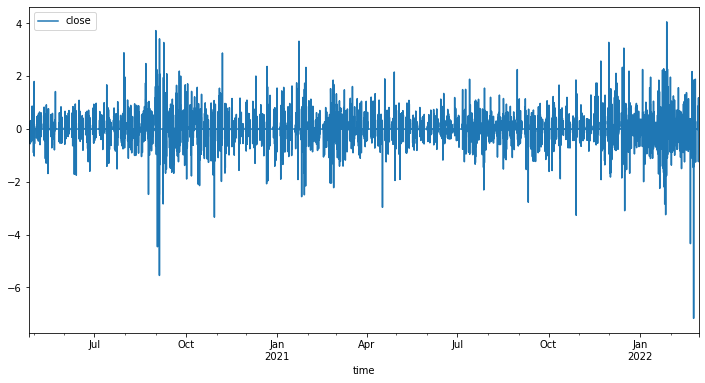

In [16]:
data_diff.plot(figsize=(12,6))

Изучим автокорреляционную(ACF) и частично автокорреляционную(PACF) функции для получившегося ряда.

d:\2022\be-rich-bot\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


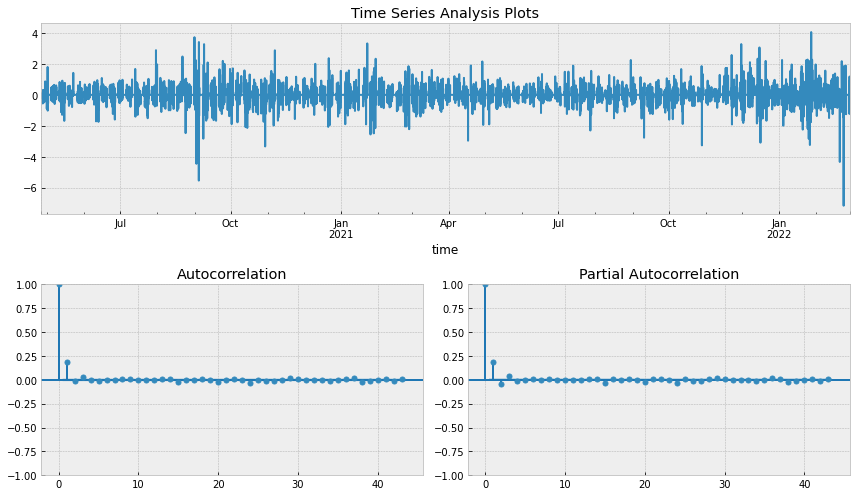

In [17]:
tsplot(data_diff['close'])

Введем начальные значения параметров модели ARIMA

In [18]:
ps = range(1, 20)
d=1
qs = range(1, 20)
Ps = range(0, 2)
D=0
Qs = range(0, 2)
s=1

# creating list with all the possible combinations of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

361

Найдем оптимальные значения параметров, минимизирующие AIC модели.

In [22]:
result_table = optimizeSARIMA(data['close'], parameters_list, d, D, s)

C:\Users\bogat\AppData\Local\Temp\ipykernel_19644\1641665125.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [20]:
result_table.head()

NameError: name 'result_table' is not defined

Строим ARIMA модель с оптимальными параметрами.

In [21]:
p, q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data['Adj Close'], order=(p, d, q)).fit(disp=-1)
print(best_model.summary())

NameError: name 'result_table' is not defined

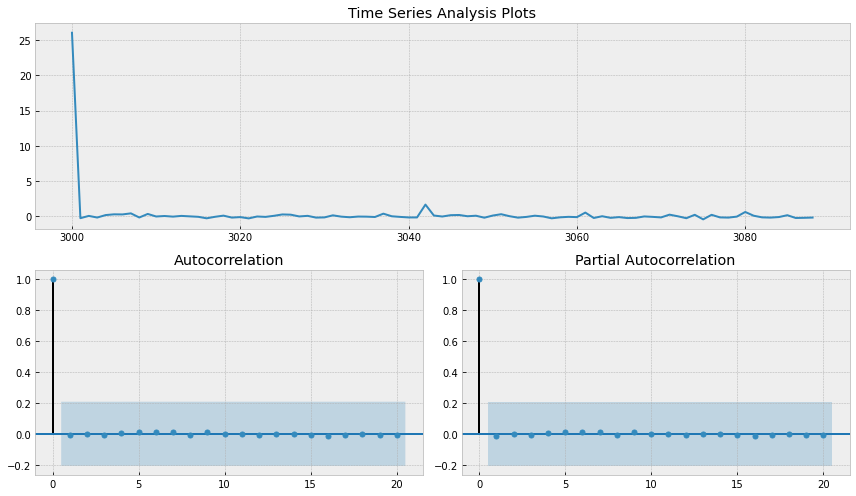

In [144]:
tsplot(best_model.resid)

Видно, что остатки стационарны и явных автокорреляций нет. Теперь можно делать прогнозы, используя нашу модель.

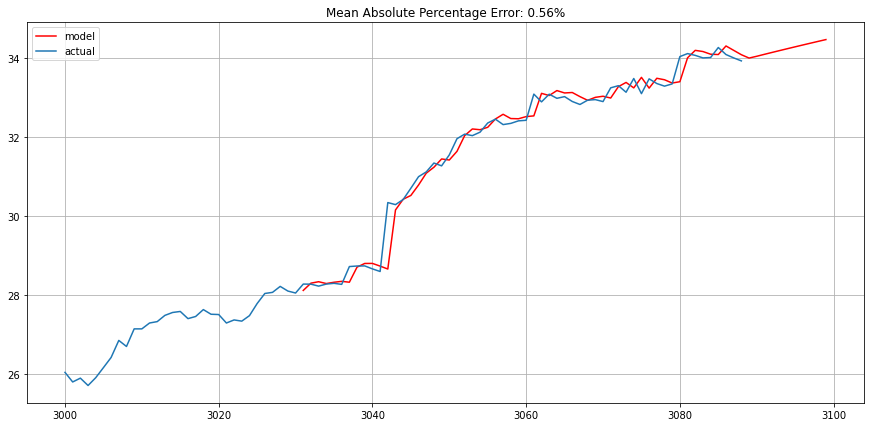

In [150]:
plotSARIMA(data, best_model, 30, 1, 10)